1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [22]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [23]:
import pandas as pd

# Specify the file path to the dataset
file_path = 'data/data_000637.txt'

# Read the first 15,000 rows from the dataset (you can adjust the value of N as needed)
N = 15000
df = pd.read_csv(file_path, nrows=N, sep='\s+')

# Display the first few rows of the DataFrame
print(df.head())

  HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0                         1,0,123,3869200167,2374,26 
1                         1,0,124,3869200167,2374,27 
2                          1,0,63,3869200167,2553,28 
3                          1,0,64,3869200167,2558,19 
4                          1,0,64,3869200167,2760,25 


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [24]:
# Split the combined string into separate columns
df[['HEAD', 'FPGA', 'TDC_CHANNEL', 'ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS']] = df['HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS'].str.split(',', expand=True)

# Convert columns to numeric (assuming they are not already)
df = df.apply(pd.to_numeric, errors='ignore')

# Identify rows where 'BX_COUNTER' reaches its maximum value before being reset to 0
max_bx_values = df[df['HEAD'] == 1].groupby('ORBIT_CNT')['BX_COUNTER'].max()

# Calculate the difference between consecutive maximum values
bx_reset_diff = max_bx_values.diff()

# Drop the first row containing NaN, as there is no previous value for the first maximum
bx_reset_diff = bx_reset_diff.dropna()

# x is the mean of the differences
x_estimate = int(bx_reset_diff.mean())

# Print the estimate of the number of BX in an ORBIT
print("Estimated value of x (number of BX in an ORBIT):", x_estimate)


Estimated value of x (number of BX in an ORBIT): 2


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [25]:
# Split the combined string into separate columns
df[['HEAD', 'FPGA', 'TDC_CHANNEL', 'ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS']] = df['HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS'].str.split(',', expand=True)

# Convert columns to numeric (assuming they are not already)
df = df.apply(pd.to_numeric, errors='ignore')

# Create a new column with absolute time in ns
df['absolute_time_ns'] = (
    (df['ORBIT_CNT'] * df['BX_COUNTER'] + df['TDC_MEAS']) * 25 / 30 +
    df['FPGA'] * 1e9  # Convert seconds to nanoseconds
)

# Introduce an offset to make the start of data acquisition (first entry) zero
offset = df['absolute_time_ns'].min()
df['absolute_time_ns'] -= offset

# Convert the new column to a Time Series
df['absolute_time'] = pd.to_datetime(df['absolute_time_ns'], unit='ns')

# Print the DataFrame with the new columns
print(df[['absolute_time_ns', 'absolute_time']].head())


   absolute_time_ns                 absolute_time
0      7.654568e+12 1970-01-01 02:07:34.567663735
1      7.654568e+12 1970-01-01 02:07:34.567663736
2      8.231723e+12 1970-01-01 02:17:11.723355315
3      8.247845e+12 1970-01-01 02:17:27.845022670
4      8.899160e+12 1970-01-01 02:28:19.160384120


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [26]:
# Split the combined string into separate columns
df[['HEAD', 'FPGA', 'TDC_CHANNEL', 'ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS']] = df['HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS'].str.split(',', expand=True)

# Convert columns to numeric (assuming they are not already)
df = df.apply(pd.to_numeric, errors='ignore')

# Create a new column with absolute time in ns
df['absolute_time_ns'] = (
    (df['ORBIT_CNT'] * df['BX_COUNTER'] + df['TDC_MEAS']) * 25 / 30 +
    df['FPGA'] * 1e9  # Convert seconds to nanoseconds
)

# Introduce an offset to make the start of data acquisition (first entry) zero
offset = df['absolute_time_ns'].min()
df['absolute_time_ns'] -= offset

# Convert the new column to a Time Series
df['absolute_time'] = pd.to_datetime(df['absolute_time_ns'], unit='ns')

# Calculate the duration of the data taking
duration_ns = df['absolute_time_ns'].max()
duration_seconds = duration_ns / 1e9  # Convert nanoseconds to seconds

# Convert the duration to hours, minutes, and seconds
hours, remainder = divmod(duration_seconds, 3600)
minutes, seconds = divmod(remainder, 60)

# Print the duration
print(f"Duration of data taking: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")


Duration of data taking: 3 hours, 11 minutes, 29.30 seconds


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [27]:
# Split the combined string into separate columns
df[['HEAD', 'FPGA', 'TDC_CHANNEL', 'ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS']] = df['HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS'].str.split(',', expand=True)

# Convert columns to numeric (assuming they are not already)
df = df.apply(pd.to_numeric, errors='ignore')

# Use groupby to find the counts of each TDC_CHANNEL
channel_counts = df['TDC_CHANNEL'].value_counts()

# Print the top 3 noisy channels and their corresponding counts
print("Top 3 Noisy Channels:")
for channel, count in channel_counts.head(3).items():
    print(f"TDC_CHANNEL: {channel}, Count: {count}")


Top 3 Noisy Channels:
TDC_CHANNEL: 139, Count: 1268
TDC_CHANNEL: 64, Count: 752
TDC_CHANNEL: 63, Count: 749


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [28]:
# Split the combined string into separate columns
df[['HEAD', 'FPGA', 'TDC_CHANNEL', 'ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS']] = df['HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS'].str.split(',', expand=True)

# Convert columns to numeric (assuming they are not already)
df = df.apply(pd.to_numeric, errors='ignore')

# Count the number of non-empty orbits (orbits with at least one hit)
non_empty_orbits = df['ORBIT_CNT'].nunique()

# Print the result
print(f"Number of non-empty orbits: {non_empty_orbits}")


Number of non-empty orbits: 150


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [29]:
# Split the combined string into separate columns
df[['HEAD', 'FPGA', 'TDC_CHANNEL', 'ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS']] = df['HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS'].str.split(',', expand=True)

# Convert columns to numeric (assuming they are not already)
df = df.apply(pd.to_numeric, errors='ignore')

# Filter rows where TDC_CHANNEL is 139
df_channel_139 = df[df['TDC_CHANNEL'] == 139]

# Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139
unique_orbits_channel_139 = df_channel_139['ORBIT_CNT'].nunique()

# Print the result
print(f"Number of unique orbits with at least one measurement from TDC_CHANNEL=139: {unique_orbits_channel_139}")


Number of unique orbits with at least one measurement from TDC_CHANNEL=139: 150


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [30]:
# Split the combined string into separate columns
df[['HEAD', 'FPGA', 'TDC_CHANNEL', 'ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS']] = df['HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS'].str.split(',', expand=True)

# Convert columns to numeric (assuming they are not already)
df = df.apply(pd.to_numeric, errors='ignore')

# Group by FPGA and TDC_CHANNEL and count the occurrences
channel_counts_by_fpga = df.groupby(['FPGA', 'TDC_CHANNEL']).size()

# Separate the counts for FPGA 0 and FPGA 1 into two Series
counts_fpga_0 = channel_counts_by_fpga.loc[0]
counts_fpga_1 = channel_counts_by_fpga.loc[1]

# Print the Series
print("Counts for FPGA 0:")
print(counts_fpga_0)

print("\nCounts for FPGA 1:")
print(counts_fpga_1)


Counts for FPGA 0:
TDC_CHANNEL
1        8
2       16
3       16
4       19
5       19
      ... 
121     63
122     71
123    202
124    193
139    879
Length: 117, dtype: int64

Counts for FPGA 1:
TDC_CHANNEL
1      338
2      363
3      277
4      290
5      189
      ... 
125      6
126      7
127     16
128     18
139    389
Length: 124, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

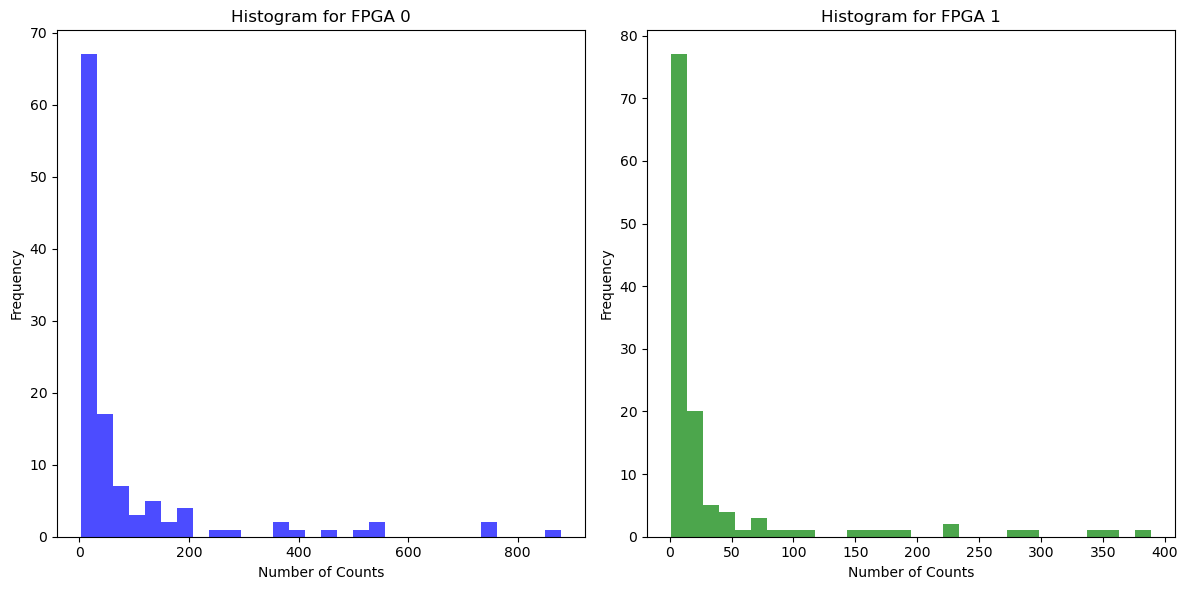

In [31]:

import matplotlib.pyplot as plt


# Split the combined string into separate columns
df[['HEAD', 'FPGA', 'TDC_CHANNEL', 'ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS']] = df['HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS'].str.split(',', expand=True)

# Convert columns to numeric (assuming they are not already)
df = df.apply(pd.to_numeric, errors='ignore')

# Group by FPGA and TDC_CHANNEL and count the occurrences
channel_counts_by_fpga = df.groupby(['FPGA', 'TDC_CHANNEL']).size()

# Separate the counts for FPGA 0 and FPGA 1 into two DataFrames
counts_fpga_0 = channel_counts_by_fpga.loc[0].reset_index(name='Counts')
counts_fpga_1 = channel_counts_by_fpga.loc[1].reset_index(name='Counts')

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(counts_fpga_0['Counts'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram for FPGA 0')
plt.xlabel('Number of Counts')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(counts_fpga_1['Counts'], bins=30, color='green', alpha=0.7)
plt.title('Histogram for FPGA 1')
plt.xlabel('Number of Counts')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
